# Project - Second Requirement

### Include packages.

In [38]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import norm

### The first thing to do is to code the environment.

In [39]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [40]:
class PricingEnvironmentMultiProduct(Environment):
    def __init__(self, costs, mean_valuations, std_valuations, buyers_per_round):
        self.N = len(costs)
        self.costs = np.array(costs)
        self.mean_valuations = np.array(mean_valuations)
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round

    def round(self, prices):
        sales_per_product = np.zeros(self.N)
        rewards_per_product = np.zeros(self.N)

        for i in range(self.N):
            p_t = prices[i]
            prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuations[i], scale=self.std_valuations[i])
            num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
            reward_i = (p_t - self.costs[i]) * num_sales

            sales_per_product[i] = num_sales
            rewards_per_product[i] = reward_i

        total_reward = np.sum(rewards_per_product)
        total_sales = np.sum(sales_per_product)
        return sales_per_product, total_reward, rewards_per_product


### Now define the setting...

In [41]:
# --- Global Settings ---

T = 20000                 # Time horizon (number of rounds)
n_trials = 10             # Number of independent trials for averaging
N = 5                     # Number of products

# --- Pricing Grid and Product Info ---

price_step = 0.5

K = 5         # Number of price options (arms per product)

costs = np.array([2.00, 1.50, 2.50, 0.50, 4.00])
values = np.array([3.00, 2.50, 3.00, 1.50, 6.00])
std_valuations = np.array([1.0, 0.8, 1.2, 0.5, 1.5])

assert len(costs) == len(values) == len(std_valuations) == N, "costs, values, std_valuations must all be of length N"
assert np.all(costs < values), "Each product's cost must be less than its corresponding value"

# --- Build per-product price grids ---
price_grids = []
for i in range(N):
    p_min = 0
    p_max = values[i] * 2
    custom_prices = np.linspace(p_min, p_max, 5)
    price_grids.append(custom_prices)

# --- Market and Inventory Parameters ---

B = 120000                         # Total inventory (shared among all products)

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50             # Per product per round
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom = 0.001              # Zoom factor for plotting
s = 30                    # random seed

### Expected demand and profit using theoretical expectations.

In [42]:
# --- Initialize matrices for expected demand/profit ---
expected_demand_matrix = []
expected_profit_matrix = []

for i in range(N):
    prices = price_grids[i]
    demands = []
    profits = []
    for p in prices:
        prob_buy = 1 - norm.cdf(p, loc=values[i], scale=std_valuations[i])
        expected_demand = buyers_per_round * prob_buy
        expected_profit = (p - costs[i]) * expected_demand
        demands.append(expected_demand)
        profits.append(expected_profit)
    expected_demand_matrix.append(demands)
    expected_profit_matrix.append(profits)

expected_demand_matrix = np.array(expected_demand_matrix)
expected_profit_matrix = np.array(expected_profit_matrix)

# --- Find best price per product ---
best_price_indices = np.argmax(expected_profit_matrix, axis=1)
best_prices = np.array([price_grids[i][idx] for i, idx in enumerate(best_price_indices)])
best_profits = expected_profit_matrix[np.arange(N), best_price_indices]

# --- Summary ---
print("=== Best Expected Prices ===")
for i in range(N):
    print(f"Product {i}: optimal price = €{best_prices[i]:.2f}, expected profit = €{best_profits[i]:.2f}")

=== Best Expected Prices ===
Product 0: optimal price = €3.00, expected profit = €25.00
Product 1: optimal price = €2.50, expected profit = €25.00
Product 2: optimal price = €3.00, expected profit = €12.50
Product 3: optimal price = €1.50, expected profit = €25.00
Product 4: optimal price = €6.00, expected profit = €50.00


### Let us visualize our setting.

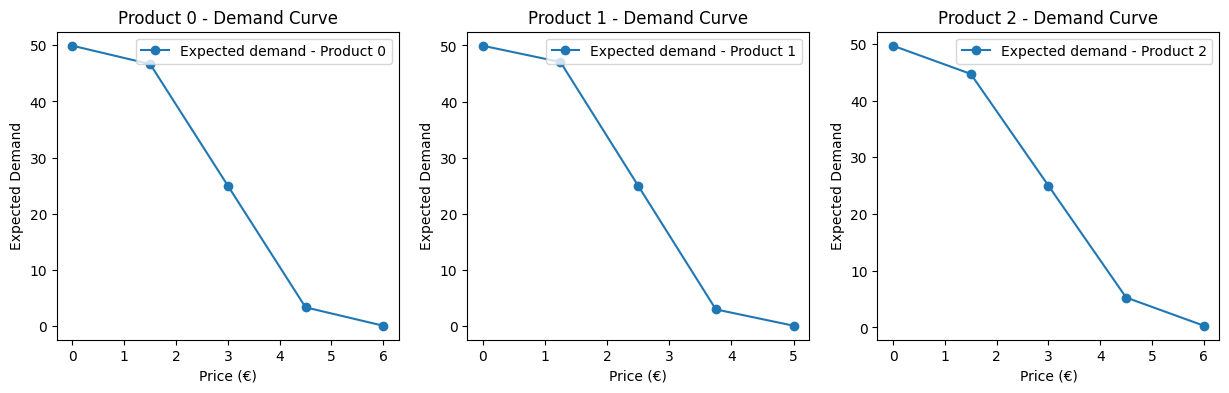

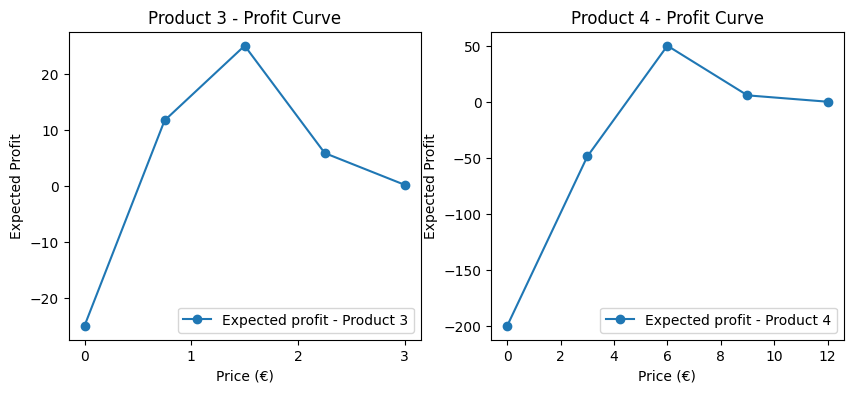

In [ ]:
# --- Visualization ---

fig1, axs1 = plt.subplots(1, 3, figsize=(15, 4))
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 4))

# Plot items 1, 2 and 3
for i in range(min(N, 3)):
    axs1[i].plot(price_grids[i], expected_demand_matrix[i], label=f'Expected demand - Product {i}', marker='o')
    axs1[i].set_title(f"Product {i} - Demand Curve")
    axs1[i].set_xlabel("Price (€)")
    axs1[i].set_ylabel("Expected Demand")
    axs1[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))  # Force integer ticks on x-axis
    axs1[i].legend()

# Plot items 4 and 5
for i in range(3, min(N, 5)):
    axs2[i-3].plot(price_grids[i], expected_profit_matrix[i], label=f'Expected profit - Product {i}', marker='o')
    axs2[i-3].set_title(f"Product {i} - Profit Curve")
    axs2[i-3].set_xlabel("Price (€)")
    axs2[i-3].set_ylabel("Expected Profit")
    axs2[i-3].xaxis.set_major_locator(matplotlib.ticker.MaxNLocatorß(integer=True))  # Force integer ticks on x-axis
    axs2[i-3].legend()